<a href="https://colab.research.google.com/github/kabinny/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,806 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

- 런타임 -> 세션 다시 시작

In [2]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [3]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [4]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [5]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [6]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [7]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [11]:
set_seed(86)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [10]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [13]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. It features a green hoodie with the word "ARM" printed on it, layered over a collared shirt and jeans, which are common items of casual wear. The focus on the garment's design and fit suggests that the photograph may be used for fashion retail or promotional purposes.
Yes.
Yes, this image is of clothing. It showcases a person wearing a textured brown coat and matching accessories that are likely designed for cold weather. The focus on the attire suggests it may be used for fashion or retail purposes to display the outfit's design and style.
Yes, this image appears to be a fashion-related photograph. The individuals are dressed in coordinated outfits that suggest they may be models showcasing clothing items for a catalog or a brand's lookbook. The setting is minimalistic and designed to highlight the garments rather than distract with extraneous details. The lighting and composition of the photo are typical of professional fashion photography, which aims 

## 14-6 의류 판단 결과 시각화

In [14]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
4,,True
5,,True
6,,False
7,,True
8,,False
9,,False


## 14-7 의류 이미지 필터링

In [15]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

In [16]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
4,,True
5,,True
7,,True
10,,True
11,,True


## 14-8 의류 스타일 분석

In [17]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-1874085826.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [18]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes in the image reflects a casual and somewhat sporty aesthetic, which is often associated with streetwear fashion. The green hoodie with its contrasting grey inner lining and cuffs, along with the white ""ARM"" text, suggests a design that favors bold lettering as a statement piece. This kind of clothing is typically comfortable and versatile, suitable for everyday wear.\n\nThe light blue denim shirt layered underneath adds a classic touch to the outfit, bridging the gap between casual and smart-casual attire. Denim is a staple fabric known for its durability and timeless appeal. The rolled-up sleeves on both the hoodie and the shirt give the ensemble a relaxed and laid-back vibe.\n\nOverall, the colors are muted yet distinct enough to make a subtle fashion statement. The combination of the green hoodie, grey accents, and light blue denim creates a harmonious color palette that is both trendy and easy to pair with other items in a wardrobe. This look could be seen as part of a modern trend where comfort meets style, particularly popular in urban settings."
1,,True,"The style of the clothes worn by the individual in the image leans towards a military-inspired aesthetic, characterized by its utilitarian design and muted color palette. The olive green jacket with its large pockets and adjustable cuffs is reminiscent of combat or workwear, which has been popularized in fashion for its rugged appeal and versatility. This trend often reflects a preference for clothing that is both functional and stylish, appealing to those who appreciate a minimalist yet robust look.\n\nThe muted tones and practical features such as multiple pockets suggest an influence from tactical gear, which has seen a resurgence in fashion due to its timeless quality and ability to blend into various settings, from urban environments to outdoor adventures. The overall style can be categorized under contemporary streetwear influences that draw on military-style garments, indicating a shift towards more casual, yet durable and adaptable fashion choices.\n\nIn terms of color trends, earthy hues like olive green are frequently used in fashion as they offer a neutral yet distinct option compared to more conventional colors. These shades are versatile and can easily complement other elements of an outfit while maintaining a cohesive look. The absence of bright colors or bold patterns further emphasizes the garment's function over form, aligning with current trends that favor simplicity and understated elegance."
2,,True,"The style of the clothes in the image leans towards a cozy, casual winter aesthetic. The use of dark brown for both the coat and hat suggests a preference for earthy tones that are often associated with fall and winter fashion. These colors tend to be versatile and can easily match with various other shades, making them popular choices for outerwear during colder months.\n\nThe texture of the coat, which appears soft and fuzzy, indicates a trend towards comfort and warmth in clothing design. Such textures are not only visually appealing but also provide additional insulation against cold weather. This kind of material is often favored by those who prioritize comfort without sacrificing style.\n\nThe oversized nature of the coat adds to the laid-back, relaxed vibe of the outfit. Oversized garments have been trending as they offer ease of movement and a more effortless look compared to fitted pieces. This trend caters to a modern, casual-chic aesthetic where functionality meets fashion.\n\nOverall, the combination of color, texture, and cut reflects a contemporary approach to winter fashion, focusing on comfort, practicality, and a touch of style."
3,,True,"The style of the clothes worn by the individuals in the image suggests a contemporary, casual fashion trend that leans towards comfort and simplicity. The choice of colors—maroon and grey—are neutral yet vibrant enough to stand out without bei

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [19]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 11-22 05:29:15 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 11-22 05:29:16 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 11-22 05:29:38 config.py:549] This model supports multiple tasks: {'reward', 'generate', 'classify', 'embed', 'score'}. Defaulting to 'generate'.
INFO 11-22 05:29:38 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 11-22 05:29:41 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-22 05:29:41 cuda.py:226] Using XFormers backend.
INFO 11-22 05:29:42 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 11-22 05:29:43 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 11-22 05:32:22 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 159.563537 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-22 05:33:02 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 11-22 05:33:05 worker.py:267] Memory profiling takes 2.47 seconds
INFO 11-22 05:33:05 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 11-22 05:33:05 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 11-22 05:33:05 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 11-22 05:33:05 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 11-22 05:33:11 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:38<00:00,  1.11s/it]

INFO 11-22 05:33:49 model_runner.py:1562] Graph capturing finished in 39 secs, took 0.21 GiB
INFO 11-22 05:33:49 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 47.59 seconds


## 14-10 색상 정보 추출

In [20]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요. \n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 11-22 05:35:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, est. speed input: 382.85 toks/s, output: 34.30 toks/s]


- 녹색 (Green)
- 회색 (Grey)
- 흰색 (White)
- 파란색 (Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s, est. speed input: 1040.19 toks/s, output: 30.00 toks/s]


**색상:**
- 올리브 그린


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, est. speed input: 1369.88 toks/s, output: 24.12 toks/s]


색상: 어두운 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s, est. speed input: 793.04 toks/s, output: 30.74 toks/s]


색상:
- 마르oon
- 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s, est. speed input: 2040.03 toks/s, output: 15.28 toks/s]


갈색


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it, est. speed input: 238.94 toks/s, output: 39.44 toks/s]


- ** denim jacket**: 짙은 파란색 (Note: Specific color not explicitly mentioned in the text, but inferred as denim typically refers to blue)
- **T-shirt**: 베이지 (Beige) 또는 연한 갈색 (Light brown)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s, est. speed input: 689.43 toks/s, output: 32.94 toks/s]


- 베이지 (Beige)
- 카키 (Khaki)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, est. speed input: 1033.35 toks/s, output: 21.71 toks/s]


갈색
베이지


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, est. speed input: 1721.12 toks/s, output: 13.24 toks/s]

회색



/tmp/ipython-input-1327615383.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [21]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요. \n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it, est. speed input: 254.00 toks/s, output: 37.96 toks/s]


- 캐주얼
- 스포티
- 스트리트웨어
- 볼드한 글자
- 편안함
- 클래식
- 스마트 캐주얼
- 내구성
- 트렌디
- 편안함과 스타일의 조화


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 164.27 toks/s, output: 40.28 toks/s]


- 군사적 영감
- 실용적 디자인
- muted 색상 팔레트
- 전투/업무용 재킷
- 기능성과 스타일의 조화
- 미니멀리즘
- 견고함
- 현대 스트리트웨어
- Tactical 기어 영향
- 자연스러운 색조 (올리브 그린 등)
- 중립적이면서 독특한 색상
- 단순함과 우아함의 조화


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it, est. speed input: 228.55 toks/s, output: 39.16 toks/s]


- cozy
- casual
- earthy tones
- versatile
- soft
- fuzzy
- comfortable
- warm
- relaxed
- laid-back
- oversized
- effortless
- contemporary
- practical
- stylish


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 140.47 toks/s, output: 40.52 toks/s]


- **현대적**
- **편안함**
- **단순함**
- **중립적**
- **활력**
- **따뜻함**
- **세련됨**
- **차분함**
- **편안함**
- **실용성**
- **미니멀리즘**
- **색상조화**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, est. speed input: 298.54 toks/s, output: 37.73 toks/s]


- 캐주얼
- rugged
- earthy
- 자연친화적
- 텍스처
- 클래식
- 실용적
- 단순함
- 기능성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it, est. speed input: 243.80 toks/s, output: 38.45 toks/s]


- 캐주얼
- 스트리트웨어
- 데님 재킷
- faded wash
- 편안함
- 접근 가능성
- 베이지/라이트 브라운
- 중립 톤
- 단순함
- 빈티지
- 기능성
- 시각적 대조


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 151.16 toks/s, output: 39.97 toks/s]


- 미니멀리즘
- 실용성
- 현대 스트리트웨어
- 중립톤 (베이지, 카키)
- 단순함
- 현대 캐주얼 패션
- 오버사이즈
- 편안함
- 유연한 실루엣
- 기능성
- 패션 포워드
- 큰 포켓 디테일
- 레이어드 스타일
- 실용적인 레이어링
- 계절 변화에 따른 유연성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 124.02 toks/s, output: 40.82 toks/s]


- 클래식 스타일
- 캐주얼 및 준포멀 웨어
- 중립적 색상 팔레트
- 브라운 & 베이지
- 타임리스 디자인
- 내구성 있는 패션
- 남성 패션 스테플
- 1970년대 & 1980년대 인기
- 2000년대 부활
- 빈티지 스타일 nods
- 현대적 감각


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 114.05 toks/s, output: 40.48 toks/s]

- 미니멀리즘
- 현대적
- 모노톤
- 그레이
-Sophistication
- Understated Elegance
- Timeless Fashion
- Oversized
- Contemporary Menswear
- Comfort
- Relaxed Silhouette
- Versatility
- Functionality
- Return to Basics
- Neutral Colors
- Simple Cuts
- Streamlined
- Polished Appearance
- Streetwear
- Casual-Chic



/tmp/ipython-input-4182576222.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [22]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes in the image reflects a casual and somewhat sporty aesthetic, which is often associated with streetwear fashion. The green hoodie with its contrasting grey inner lining and cuffs, along with the white ""ARM"" text, suggests a design that favors bold lettering as a statement piece. This kind of clothing is typically comfortable and versatile, suitable for everyday wear.\n\nThe light blue denim shirt layered underneath adds a classic touch to the outfit, bridging the gap between casual and smart-casual attire. Denim is a staple fabric known for its durability and timeless appeal. The rolled-up sleeves on both the hoodie and the shirt give the ensemble a relaxed and laid-back vibe.\n\nOverall, the colors are muted yet distinct enough to make a subtle fashion statement. The combination of the green hoodie, grey accents, and light blue denim creates a harmonious color palette that is both trendy and easy to pair with other items in a wardrobe. This look could be seen as part of a modern trend where comfort meets style, particularly popular in urban settings.",- 녹색 (Green)\n- 회색 (Grey)\n- 흰색 (White)\n- 파란색 (Blue),- 캐주얼\n- 스포티\n- 스트리트웨어\n- 볼드한 글자\n- 편안함\n- 클래식\n- 스마트 캐주얼\n- 내구성\n- 트렌디\n- 편안함과 스타일의 조화
1,,True,"The style of the clothes worn by the individual in the image leans towards a military-inspired aesthetic, characterized by its utilitarian design and muted color palette. The olive green jacket with its large pockets and adjustable cuffs is reminiscent of combat or workwear, which has been popularized in fashion for its rugged appeal and versatility. This trend often reflects a preference for clothing that is both functional and stylish, appealing to those who appreciate a minimalist yet robust look.\n\nThe muted tones and practical features such as multiple pockets suggest an influence from tactical gear, which has seen a resurgence in fashion due to its timeless quality and ability to blend into various settings, from urban environments to outdoor adventures. The overall style can be categorized under contemporary streetwear influences that draw on military-style garments, indicating a shift towards more casual, yet durable and adaptable fashion choices.\n\nIn terms of color trends, earthy hues like olive green are frequently used in fashion as they offer a neutral yet distinct option compared to more conventional colors. These shades are versatile and can easily complement other elements of an outfit while maintaining a cohesive look. The absence of bright colors or bold patterns further emphasizes the garment's function over form, aligning with current trends that favor simplicity and understated elegance.",**색상:**\n- 올리브 그린,- 군사적 영감\n- 실용적 디자인\n- muted 색상 팔레트\n- 전투/업무용 재킷\n- 기능성과 스타일의 조화\n- 미니멀리즘\n- 견고함\n- 현대 스트리트웨어\n- Tactical 기어 영향\n- 자연스러운 색조 (올리브 그린 등)\n- 중립적이면서 독특한 색상\n- 단순함과 우아함의 조화
2,,True,"The style of the clothes in the image leans towards a cozy, casual winter aesthetic. The use of dark brown for both the coat and hat suggests a preference for earthy tones that are often associated with fall and winter fashion. These colors tend to be versatile and can easily match with various other shades, making them popular choices for outerwear during colder months.\n\nThe texture of the coat, which appears soft and fuzzy, indicates a trend towards comfort and warmth in clothing design. Such textures are not only visually appealing but also provide additional insulation against cold weather. This kind of material is often favored by those who prioritize comfort without sacrificing style.\n\nThe oversized nature of the coat adds to the laid-back, relaxed vibe of the outfit. Oversized garments have been trending as they offer ease of movement and a more effortless look compared to fitted pieces. This trend caters to a modern, casual-chic aesthetic where functionality meets fashion.\n\nOverall, the combination of color, texture, and cut reflects a contempor

## 14-12 텍스트 데이터 정제

In [23]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

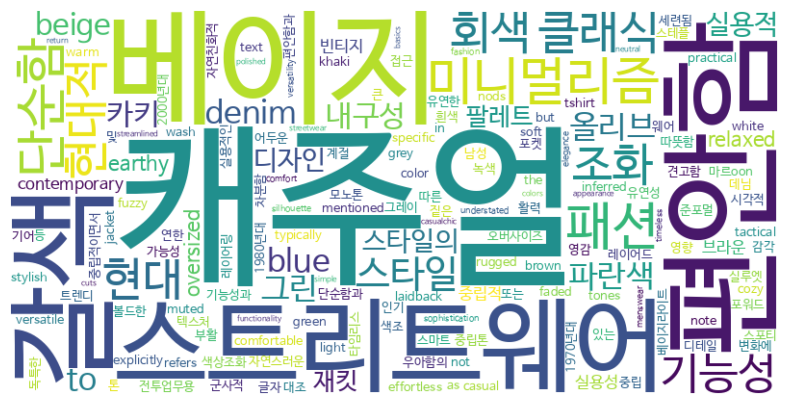

In [24]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [28]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url: {row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트렌드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서의 형식은 markdown으로 만들어주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:19<00:00, 19.27s/it, est. speed input: 141.61 toks/s, output: 38.88 toks/s]


In [29]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 요약
본 보고서는 최근 다양한 해외 패션 룩북에서 관찰되는 주요 트렌드를 분석하고, 각 컬렉션의 스타일 요소와 그 의미를 종합적으로 평가합니다. 주요 트렌드는 편안함, 실용성, 그리고 현대적인 미니멀리즘에 중점을 두고 있으며, 다양한 시즌과 컨텍스트에 걸쳐 일관성을 보입니다.

## 트렌드 분석

### 1. **편안함과 실용성의 강조**
   - **스타일 요소**: 
     - **오버사이즈 아이템**: 여러 룩북에서 오버사이즈 코트와 재킷이 주요 요소로 등장합니다. 이는 편안함과 동시에 현대적인 캐주얼 스타일을 제공합니다.
     - **기능성 소재**: Denim, Knitted 소재 등이 활용되어 내구성과 편안함을 동시에 추구합니다.
     - **실용적 액세서리**: 버킷햇, 다양한 포켓이 있는 재킷 등이 일상적인 활동과 패션을 조화롭게 결합합니다.
   - **의미**: 소비자들은 특히 계절 변화가 큰 시기에 실용적인 의류를 선호하며, 이는 일상 생활과 패션 사이의 균형을 중요시하는 경향을 반영합니다.

### 2. **미니멀리즘과 중립적 색상 팔레트**
   - **스타일 요소**:
     - **모노톤 컬러**: 베이지, 그레이, 올리브 그린 등 중립적인 색상이 주요 색상으로 사용됩니다. 이는 시각적 균형과 세련됨을 제공합니다.
     - **간결한 디자인**: 복잡한 패턴이나 장식보다는 단순하고 깔끔한 디자인이 선호됩니다.
     - **기능적 레이어링**: 여러 아이템을 겹쳐 입는 방식으로 계절 변화에 유연하게 대응합니다.
   - **의미**: 현대 패션 트렌드는 과도한 장식보다는 본질적인 아름다움과 기능성을 중시하며, 이는 소비자들이 지속 가능한 패션 선택을 추구하는 경향과도 연결됩니다.

### 3. **복고와 현대의 융합**
   - **스타일 요소**:
     - **클래식한 디테일**: 1980년대와 1990년대의 스트리트웨어 요소가 현대적인 디자인에 통합됩니다 (예: 오버사이즈 재킷, 빈티지 스타일의 부츠).
     - **타임리스 디자인**: 과거의 클래식한 아이템들이 현대적인 해석을 통해 재해석됩니다 (예: 빈티지 스타일의 코트, 클래식한 실루엣의 재킷).
   - **의미**: 이러한 융합은 과거의 영감을 현대적 맥락에 맞게 재해석하여 지속 가능한 패션 트렌드를 형성합니다. 소비자들은 과거의 아름다움을 현대적으로 재해석한 제품에 매력을 느낍니다.

## 결론
최근 해외 패션 룩북들은 편안함과 실용성을 중심으로 한 미니멀리즘 트렌드를 주도하고 있습니다. 중립적인 색상 팔레트와 간결한 디자인은 시각적 균형과 세련됨을 제공하며, 과거의 클래식한 요소와 현대적 해석의 융합은 지속 가능한 패션 선택의 중요성을 강조합니다. 이러한 트렌드는 소비자들이 일상 생활과 패션 사이의 균형을 찾고자 하는 욕구를 반영하며, 미래의 패션 디자인에도 지속적인 영향을 미칠 것으로 예상됩니다.

---

이 보고서는 주어진 이미지와 스타일 노트를 바탕으로 작성되었으며, 다양한 패션 트렌드의 핵심 요소와 그 의미를 명확하게 요약하였습니다.